# My project for Optimization Course

Multivariate linear regression implemented through solving an optimization problem using the gradient descent method and some of its variants.

The dataset used was taken from Kaggle.com and concerns house prices in the New York area. The idea is to perform a linear regression using the price as the dependent variable and the number of bedrooms, number of bathrooms, and the size of the house as independent variables.

In [1]:

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("dataset/NY-House-Dataset.csv")
print(df.head())



                                         BROKERTITLE                TYPE   
0        Brokered by Douglas Elliman  -111 Fifth Ave      Condo for sale  \
1                                Brokered by Serhant      Condo for sale   
2                             Brokered by Sowae Corp      House for sale   
3                                Brokered by COMPASS      Condo for sale   
4  Brokered by Sotheby's International Realty - E...  Townhouse for sale   

       PRICE  BEDS       BATH  PROPERTYSQFT   
0     315000     2   2.000000        1400.0  \
1  195000000     7  10.000000       17545.0   
2     260000     4   2.000000        2015.0   
3      69000     3   1.000000         445.0   
4   55000000     7   2.373861       14175.0   

                                             ADDRESS                    STATE   
0                               2 E 55th St Unit 803       New York, NY 10022  \
1  Central Park Tower Penthouse-217 W 57th New Yo...       New York, NY 10019   
2                

1) Data Cleaning


In [2]:
#ELIMINO LE COLONNE NON DESIDERATE

columns_to_drop = ["ADDRESS", "STATE", "MAIN_ADDRESS", "ADMINISTRATIVE_AREA_LEVEL_2", 
                   "LOCALITY", "STREET_NAME", "LONG_NAME", "FORMATTED_ADDRESS", 
                   "LATITUDE", "LONGITUDE","TYPE","SUBLOCALITY","BROKERTITLE"]
df_filtered = df.drop(columns=columns_to_drop)


#FILTRO GLI OUTLIER

vars = ["PRICE", "BEDS", "BATH", "PROPERTYSQFT"]
#df_filtered = df.copy()

# Filtra i valori anomali utilizzando il concetto di IQR
for var in vars:
    Q1 = df_filtered[var].quantile(0.25)
    Q3 = df_filtered[var].quantile(0.75)
    
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    
    df_filtered = df_filtered[(df_filtered[var] >= lower_limit) & (df_filtered[var] <= upper_limit)]
    
print(df_filtered.head)
    


<bound method NDFrame.head of         PRICE  BEDS  BATH  PROPERTYSQFT
0      315000     2   2.0   1400.000000
2      260000     4   2.0   2015.000000
3       69000     3   1.0    445.000000
6      899500     2   2.0   2184.207862
8      265000     1   1.0    750.000000
...       ...   ...   ...           ...
4796   599000     1   1.0   2184.207862
4797   245000     1   1.0   2184.207862
4798  1275000     1   1.0   2184.207862
4799   598125     2   1.0    655.000000
4800   349000     1   1.0    750.000000

[3659 rows x 4 columns]>


Regression Model:

$y = w_0 + w_1 x1 + w_2 x2 + w_3 x3$

In this case:

$PRICE = w_0 + w_1 BEDS + w_2 BATH + w_3 PROPERTYSQFT$



In [3]:
def standardize(x):
    """Standardize the original data points (mean 0 and std dev 1)."""
    x = x - np.mean(x)
    x = x / np.std(x)
    return x

def build_model_data(x, y):
    """Get regression data in matrix form."""
    b = y
    num_samples = len(b)
    A = np.c_[np.ones(num_samples), x]
    return A, b



In [30]:

features = df_filtered[['BEDS','BATH']]
prices = df_filtered['PRICE']
print(features)
print(prices)

A, b = build_model_data(standardize(features), standardize(prices))
A = np.array(A)
b = np.array(b)

cond_number = np.linalg.cond(A)
print("Numero di condizionamento di A:", cond_number)




      BEDS  BATH
0        2   2.0
2        4   2.0
3        3   1.0
6        2   2.0
8        1   1.0
...    ...   ...
4796     1   1.0
4797     1   1.0
4798     1   1.0
4799     2   1.0
4800     1   1.0

[3659 rows x 2 columns]
0        315000
2        260000
3         69000
6        899500
8        265000
         ...   
4796     599000
4797     245000
4798    1275000
4799     598125
4800     349000
Name: PRICE, Length: 3659, dtype: int64
Numero di condizionamento di A: 3.034159332975248


In [31]:
print('Number of samples n = ', b.shape[0])
print('Dimension of each sample d = ', A.shape[1])

Number of samples n =  3659
Dimension of each sample d =  3


1. Gradient descendent method functions

In [78]:
def calculate_objective(Axmb):
    """Calculate ||Ax - b||^2 for the vector Axmb = Ax - b"""
    # ***************************************************
    # YOUR CODE HERE
    obj = (Axmb**2).sum()
    # ***************************************************    
    return obj

def compute_gradient(A, x, b):
    """Compute the gradient and objective function."""
    # ***************************************************
    # YOUR CODE HERE
    Axmb = A.dot(x) - b
    grad = 2 * A.T.dot(Axmb)
    # ***************************************************
    return grad, Axmb

def gradient_descent(A, initial_x, b, max_iters, gamma):
    """Gradient descent algorithm."""
    # Define parameters to store x and objective func. values
    xs = [initial_x]
    objectives = []
    x = initial_x
    for n_iter in range(max_iters):
      
        # compute objective and gradient
        grad, Axmb = compute_gradient(A, x, b)
        obj = calculate_objective(Axmb)

        # ***************************************************
        # YOUR CODE HERE
        # update x by a gradient descent step
        x = x - gamma * grad
        # ***************************************************
        
        # store x and objective function value
        xs.append(x)
        objectives.append(obj)
        
        print("Gradient Descent({bi}/{ti}): objective={l:.5f}, x=[{w0:.5f},{w1:.5f}]".format(
              bi=n_iter, ti=max_iters - 1, l=obj, w0=x[0], w1=x[1]))

    return objectives, xs


test Classic Gradient descent 

In [110]:

max_iters = 500
gamma = 0.00001  # Tasso di apprendimento iniziale
x_initial = np.zeros(A.shape[1])



# Start gradient descent.
gradient_objectives_naive, gradient_xs_naive = gradient_descent(A, x_initial, b, max_iters, gamma)
print("########################")




Gradient Descent(0/499): objective=3659.00000, x=[-0.00000,0.02262]
Gradient Descent(1/499): objective=3486.40672, x=[0.00127,0.04234]
Gradient Descent(2/499): objective=3354.43280, x=[0.00355,0.05950]
Gradient Descent(3/499): objective=3253.01283, x=[0.00664,0.07439]
Gradient Descent(4/499): objective=3174.63264, x=[0.01037,0.08728]
Gradient Descent(5/499): objective=3113.67235, x=[0.01459,0.09840]
Gradient Descent(6/499): objective=3065.92071, x=[0.01918,0.10795]
Gradient Descent(7/499): objective=3028.21554, x=[0.02404,0.11611]
Gradient Descent(8/499): objective=2998.17731, x=[0.02911,0.12305]
Gradient Descent(9/499): objective=2974.01133, x=[0.03430,0.12891]
Gradient Descent(10/499): objective=2954.36082, x=[0.03958,0.13381]
Gradient Descent(11/499): objective=2938.19744, x=[0.04489,0.13786]
Gradient Descent(12/499): objective=2924.73981, x=[0.05021,0.14116]
Gradient Descent(13/499): objective=2913.39252, x=[0.05550,0.14381]
Gradient Descent(14/499): objective=2903.70060, x=[0.0607

We can try also to use a smoothness gradient descent with L parameter

In [72]:
def calculate_L(A, b):
    """Calculate the smoothness constant for f"""
    # ***************************************************
    # YOUR CODE HERE
    # compute L = smoothness constant of f
    L = 2 * np.linalg.norm(A.T.dot(A), ord=2)
    # ***************************************************
    return L

In [81]:

max_iters = 500
gamma_smooth = (1/calculate_L(A,b))
print(gamma_smooth)
x_initial = np.zeros(A.shape[1])

# Start gradient descent.
gradient_objectives_smooth, gradient_xs_smooth = gradient_descent(A, x_initial, b, max_iters, gamma_smooth)


6.865455531893832e-05
Gradient Descent(0/499): objective=3659.00000, x=[-0.00000,0.15529]
Gradient Descent(1/499): objective=2943.48948, x=[0.05973,0.17393]
Gradient Descent(2/499): objective=2884.76876, x=[0.09798,0.16488]
Gradient Descent(3/499): objective=2855.28225, x=[0.12759,0.14915]
Gradient Descent(4/499): objective=2833.39107, x=[0.15264,0.13282]
Gradient Descent(5/499): objective=2816.13504, x=[0.17457,0.11758]
Gradient Descent(6/499): objective=2802.43655, x=[0.19399,0.10379]
Gradient Descent(7/499): objective=2791.55348, x=[0.21127,0.09144]
Gradient Descent(8/499): objective=2782.90642, x=[0.22666,0.08041]
Gradient Descent(9/499): objective=2776.03588, x=[0.24038,0.07057]
Gradient Descent(10/499): objective=2770.57688, x=[0.25260,0.06180]
Gradient Descent(11/499): objective=2766.23942, x=[0.26350,0.05399]
Gradient Descent(12/499): objective=2762.79308, x=[0.27321,0.04702]
Gradient Descent(13/499): objective=2760.05478, x=[0.28187,0.04081]
Gradient Descent(14/499): objective

LIPSCHITZ

In [82]:
max_iters = 500
R = 25

# ***************************************************
# YOUR CODE HERE
# Compute the bound B on the gradient norm
B = 2 * (R*np.linalg.norm(np.dot(A.T,A)) + np.linalg.norm(np.dot(A.T,b)))
# ***************************************************

# ***************************************************
# YOUR CODE HERE
#  Compute learning rate based on bounded gradient
gamma_bounded = R/(B*np.sqrt(max_iters))
# ***************************************************

# Start gradient descent.
gradient_objectives_bounded, gradient_xs_bounded = gradient_descent(A, x_initial, b, max_iters, gamma_bounded)

Gradient Descent(0/499): objective=3659.00000, x=[-0.00000,0.00561]
Gradient Descent(1/499): objective=3614.01115, x=[0.00008,0.01104]
Gradient Descent(2/499): objective=3571.79748, x=[0.00023,0.01630]
Gradient Descent(3/499): objective=3532.17854, x=[0.00045,0.02139]
Gradient Descent(4/499): objective=3494.98589, x=[0.00074,0.02632]
Gradient Descent(5/499): objective=3460.06230, x=[0.00110,0.03109]
Gradient Descent(6/499): objective=3427.26097, x=[0.00151,0.03571]
Gradient Descent(7/499): objective=3396.44484, x=[0.00198,0.04017]
Gradient Descent(8/499): objective=3367.48595, x=[0.00251,0.04449]
Gradient Descent(9/499): objective=3340.26479, x=[0.00308,0.04867]
Gradient Descent(10/499): objective=3314.66976, x=[0.00371,0.05271]
Gradient Descent(11/499): objective=3290.59662, x=[0.00438,0.05662]
Gradient Descent(12/499): objective=3267.94800, x=[0.00509,0.06040]
Gradient Descent(13/499): objective=3246.63295, x=[0.00585,0.06405]
Gradient Descent(14/499): objective=3226.56649, x=[0.0066

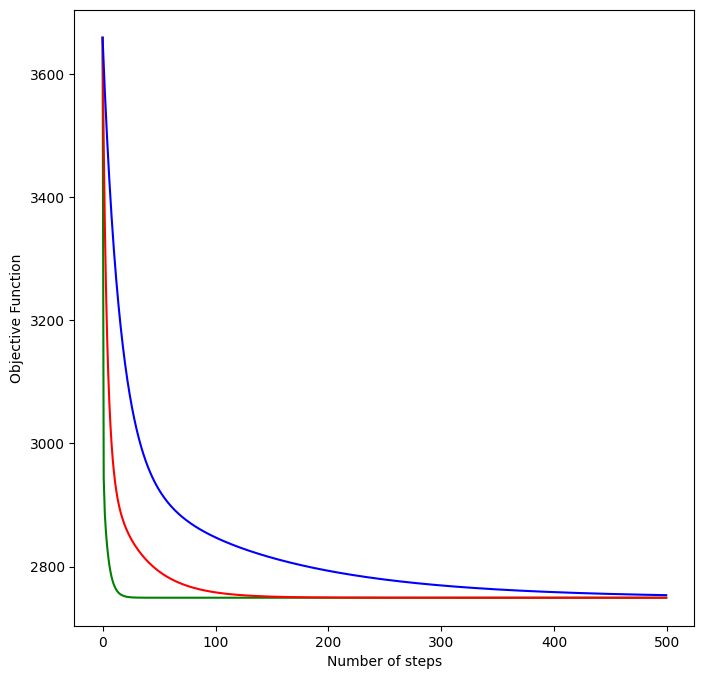

In [83]:
plt.figure(figsize=(8, 8))
plt.xlabel('Number of steps')
plt.ylabel('Objective Function')
plt.plot(range(len(gradient_objectives_smooth)), gradient_objectives_smooth,'green', label='gradient descent assuming smoothness')
plt.plot(range(len(gradient_objectives_naive)), gradient_objectives_naive,'red', label='naive gradient descent')
plt.plot(range(len(gradient_objectives_bounded)), gradient_objectives_bounded,'blue', label='gradient descent assuming bounded gradients')

STOCHASTIC GRADIENT


In [38]:
def full_objective(A, x, b):
    """Compute the least squares objective over the whole dataset"""
    return np.mean((A.dot(x) - b)**2)

x_star = np.linalg.solve(A.T.dot(A), A.T.dot(b)) #solve Ax = b
best_objective = full_objective(A, x_star, b)
print("f(x*) = ", best_objective)

f(x*) =  0.7514251541651364


In [43]:
def minibatch_gradient(A, x, b):
    """
    Compute a mini-batch stochastic gradient from a subset of `num_examples` from the dataset.
    
    :param b: a numpy array of shape (num_examples)
    :param A: a numpy array of shape (num_examples, num_features)
    :param x: compute the mini-batch gradient at these parameters, numpy array of shape (num_features)
    
    :return: gradient: numpy array of shape (num_features)
    """
    # ***************************************************
    # YOUR CODE HERE
    # TODO: implement gradient computation.
    # ***************************************************
    batch_size = len(b)
    Axmb = A.dot(x) - b
    gradient = A.T.dot(Axmb) / batch_size
    return gradient

In [44]:
num_trials = 10
for i in range(num_trials):
    # Try different parameter vectors $x$
    x = np.random.rand(A.shape[1])

    stochastic_gradients = []
    # *********************************************************
    # YOUR CODE HERE
    # TODO: Compute all stochastic gradients, mini-batch size 1
    # *********************************************************
    for i in range(len(b)):
        stochastic_gradients.append(minibatch_gradient(A[i:i+1, :], x, b[i:i+1]))

    # axis = 0 is the mean along the column
    mean_stochastic_gradients = np.mean(stochastic_gradients, axis = 0)

    # *********************************************************
    # YOUR CODE HERE
    # *********************************************************
    full_gradient = minibatch_gradient(A, x, b)

    # Those should be the same on average
    assert np.allclose(mean_stochastic_gradients, full_gradient)
    
print('Tests passed')

Tests passed


In [45]:
def stochastic_gradient(A, x, b, batch_size=1):
    """Compute a stochastic gradient"""
    dataset_size = len(b)
    indices = np.random.choice(dataset_size, batch_size, replace=False)
    return minibatch_gradient(A[indices, :], x, b[indices])

def stochastic_gradient_descent(
        data_A, 
        initial_x, 
        targets_b, 
        batch_size, 
        max_iters, 
        learning_rate):
    """
    Mini-batch Stochastic Gradient Descent for Linear Least Squares problems.
    
    :param data_A: numpy array of size (num_examples, num_features)
    :param initial_x: starting parameters, a numpy array of size (num_features)
    :param targets_b: numpy array of size (num_examples)
    :param batch_size: size of the mini-batches
    :param max_iters: integer, number of updates to do
    :param learning_rate: float
    :param decreasing_learning_rate: if true, the learning rate should decay as 1 / t 
    
    :return:
    - objectives, a list of loss values on the whole dataset, collected at the end of each pass over the dataset (epoch)
    - xs, a list of parameter vectors, collected at the end of each pass over the dataset
    """
    xs = [initial_x]  # parameters after each update 
    objectives = []  # loss values after each update
    x = initial_x
    
    # ***************************************************
    # YOUR CODE HERE
    # TODO: implement stochastic gradient descent.
    # ***************************************************
    for iteration in range(max_iters):
        grad = stochastic_gradient(data_A, x, targets_b, batch_size=batch_size)

        # update x through the stochastic gradient update
        x = x - learning_rate * grad

        # store x and objective
        xs.append(x.copy())
        objective = full_objective(data_A, x, targets_b)
        objectives.append(objective)
        
        if iteration % 1000 == 0:
            print("SGD({bi:04d}/{ti:04d}): objective = {l:10.2f}".format(
                  bi=iteration, ti=max_iters - 1, l=objective))

    return objectives, xs

SGD(0000/3999): objective =       1.00
SGD(1000/3999): objective =       0.80
SGD(2000/3999): objective =       0.78
SGD(3000/3999): objective =       0.77
SGD: execution time=1.133 seconds
0.7514251541651364


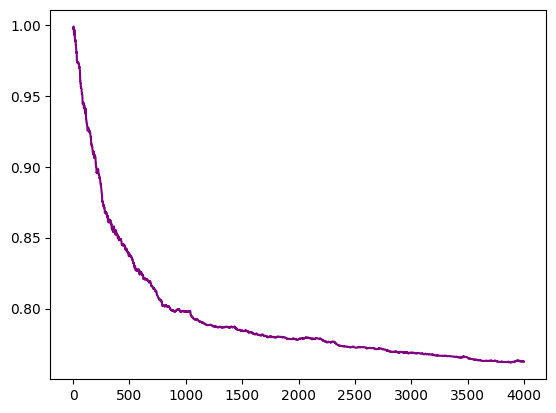

In [106]:
import datetime

# Define the parameters of the algorithm.
max_iters = int(4000)
gamma = 0.001   # this is totally arbitrary
batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
sgd_objectives, sgd_xs = stochastic_gradient_descent(A, x_initial, b, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))
plt.plot(range(len(sgd_objectives)), sgd_objectives,'purple', label='gradient descent assuming smoothness')
print(best_objective)


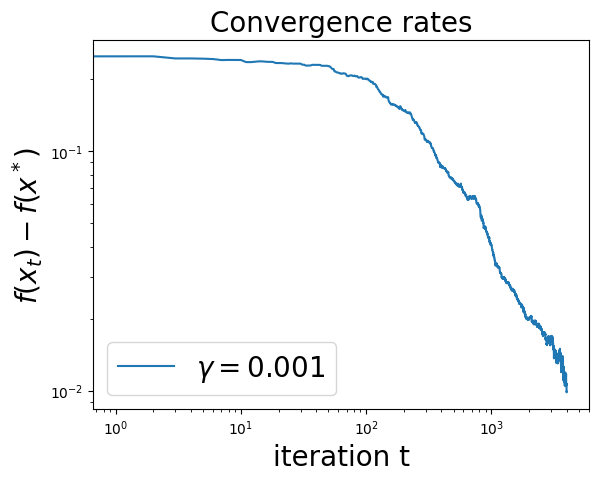

In [93]:
plt.title('Convergence rates', fontsize = 20)
plt.loglog(sgd_objectives - best_objective, label = r'$\gamma = 0.001$')
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t) - f(x^*)$', fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

METODO Adam

In [94]:
def adam(A, initial_x, b, max_iters, alpha, beta1, beta2, epsilon):
    """Adam optimization algorithm."""
    x = initial_x
    m = np.zeros_like(x)  # Moment estimates
    v = np.zeros_like(x)  # Squared gradient estimates
    t = 0                # Time step
    objectives = []
    xs = [x]
    
    for n_iter in range(max_iters):
        t += 1
        grad, Axmb = compute_gradient(A, x, b)
        obj = calculate_objective(Axmb)
        
        # Update moments
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)
        
        # Bias correction
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)
        
        # Update parameters
        x = x - alpha * m_hat / (np.sqrt(v_hat) + epsilon)
        
        # Store results
        xs.append(x)
        objectives.append(obj)
        
        # Print statement for debugging
        if n_iter % 100 == 0:
            print(f"Adam({n_iter}/{max_iters - 1}): objective={obj:.5f}, x=[{x[0]:.5f},{x[1]:.5f}]")
    
    return objectives, xs


Adam(0/49): objective=3659.00000, x=[-0.00000,0.10000]
Adam(1/49): objective=3191.71574, x=[0.07441,0.19352]
Adam(2/49): objective=2959.13196, x=[0.11917,0.26380]
Adam(3/49): objective=2922.48577, x=[0.13241,0.29533]
Adam(4/49): objective=2965.85434, x=[0.16499,0.29171]
Adam(5/49): objective=2997.76025, x=[0.21733,0.26334]
Adam(6/49): objective=2979.79917, x=[0.27426,0.21864]
Adam(7/49): objective=2925.60623, x=[0.31103,0.16349]
Adam(8/49): objective=2857.77439, x=[0.32177,0.10252]
Adam(9/49): objective=2795.37181, x=[0.32320,0.04017]
Adam(10/49): objective=2758.32208, x=[0.33249,-0.01898]
Adam(11/49): objective=2751.48899, x=[0.35491,-0.07062]
Adam(12/49): objective=2766.89086, x=[0.38368,-0.11144]
Adam(13/49): objective=2792.86466, x=[0.40714,-0.13972]
Adam(14/49): objective=2815.30763, x=[0.41790,-0.15526]
Adam(15/49): objective=2823.25556, x=[0.41968,-0.15897]
Adam(16/49): objective=2816.73047, x=[0.42213,-0.15253]
Adam(17/49): objective=2802.38980, x=[0.43241,-0.13825]
Adam(18/49)

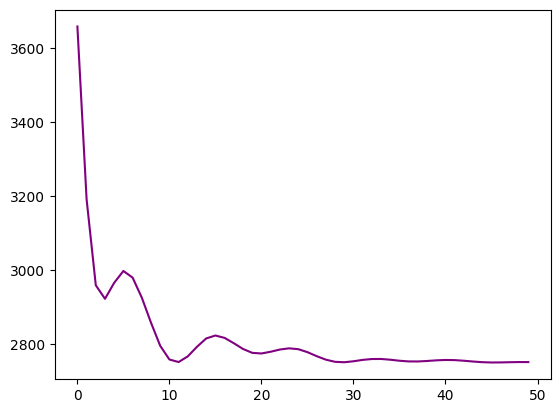

In [111]:
alpha = 0.1 # Tasso di apprendimento
beta1 = 0.9    # Coefficiente per il momento del primo ordine
beta2 = 0.999  # Coefficiente per il momento del secondo ordine
epsilon = 1e-8 # Termine di regolarizzazione
max_iters = 50
initial_x = np.zeros(A.shape[1])
objectives, xs = adam(A, initial_x, b, max_iters, alpha, beta1, beta2, epsilon)
plt.plot(range(len(objectives)), objectives,'purple', label='gradient descent assuming smoothness')